In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, numpy as np, torch
import shutil

In [ ]:
def build_topk_transition(A: torch.Tensor, k: int = 32, eps: float = 1e-8):
    """
    A: (N,N) nonnegative
    Returns sparse row-normalized transition matrix P (N,N) with top-k per row.
    """
    N = A.shape[0]

    # topk indices/values per row
    vals, idx = torch.topk(A, k=min(k, N), dim=1)

    row_idx = torch.arange(N, device=A.device).unsqueeze(1).expand_as(idx).reshape(-1)
    col_idx = idx.reshape(-1)
    w = vals.reshape(-1)

    # row-normalize
    row_sum = torch.zeros(N, device=A.device).scatter_add_(0, row_idx, w)
    w = w / (row_sum[row_idx] + eps)

    indices = torch.stack([row_idx, col_idx], dim=0)
    P = torch.sparse_coo_tensor(indices, w, size=(N, N)).coalesce()
    return P

In [ ]:
def graph_diffuse(A_np: np.ndarray, k: int = 32, steps: int = 3, alpha: float = 0.35):
    """
    Simple graph diffusion:
      X_{t+1} = alpha*A + (1-alpha) * P * X_t
    with P built from top-k edges of A.
    Symmetrize after each step.
    """
    A = torch.from_numpy(A_np).float()
    A = torch.relu(A)  # enforce non-neg

    P = build_topk_transition(A, k=k)

    X = A.clone()
    for _ in range(steps):
        X = alpha * A + (1.0 - alpha) * torch.sparse.mm(P, X)
        X = 0.5 * (X + X.T)  # keep symmetric

    return X.cpu().numpy()

In [ ]:
# LOAD PRED ----
UNC_DIR = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty"
pred_mean_path = f"{UNC_DIR}/pred_uncertainty_mean.npy"
gt_path = f"{UNC_DIR}/gt_chr19.npy"  # or your GT_PATH copy

pred_mean = np.load(pred_mean_path)  # (3,N,N)
gt = np.load(gt_path)

print("pred_mean:", pred_mean.shape, "gt:", gt.shape)

pred_mean: (3, 1534, 1534) gt: (6, 1534, 1534)


In [ ]:
# APPLY GRAPH DIFFUSION PER FUTURE STEP 
pred_graph = np.stack([graph_diffuse(pred_mean[t], k=32, steps=3, alpha=0.35) for t in range(pred_mean.shape[0])], axis=0)

In [ ]:
# SAVE
OUT_DIR = "/content/drive/MyDrive/HiCForecast_Project_experiment_2"
os.makedirs(OUT_DIR, exist_ok=True)

np.save(f"{OUT_DIR}/pred_graphdiff.npy", pred_graph)
print("Saved:", f"{OUT_DIR}/pred_graphdiff.npy")

Saved: /content/drive/MyDrive/HiCForecast_Project_experiment_2/pred_graphdiff.npy


In [ ]:
#Copy GT into OUT_DIR
UNC_DIR = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty"

os.makedirs(OUT_DIR, exist_ok=True)

shutil.copy(f"{UNC_DIR}/gt_chr19.npy", f"{OUT_DIR}/gt_chr19.npy")
print("Copied GT to:", f"{OUT_DIR}/gt_chr19.npy")

Copied GT to: /content/drive/MyDrive/HiCForecast_Project_experiment_2/gt_chr19.npy


# **Evaluate graphdiff with fixed matching [2,5,5]**

In [ ]:
import numpy as np, csv
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

pred = np.load(f"{OUT_DIR}/pred_graphdiff.npy").astype(np.float32)   # (3,N,N)
gt   = np.load(f"{OUT_DIR}/gt_chr19.npy").astype(np.float32)         # (T,N,N)

fixed = [2, 5, 5]

def pcc(a, b, eps=1e-12):
    a = a.astype(np.float64).ravel()
    b = b.astype(np.float64).ravel()
    a -= a.mean(); b -= b.mean()
    return float((a @ b) / (np.sqrt((a @ a) + eps) * np.sqrt((b @ b) + eps)))

def diagonal_patches(M, patch=60, stride=60):
    N = M.shape[0]
    out = []
    for s in range(0, N - patch + 1, stride):
        p = M[s:s+patch, s:s+patch]
        if np.any(p):
            out.append(p)
    return out

def avg_patch_metrics(X, Y, patch=60, stride=60):
    Xp = diagonal_patches(X, patch=patch, stride=stride)
    Yp = diagonal_patches(Y, patch=patch, stride=stride)
    m = min(len(Xp), len(Yp))
    if m == 0:
        return {"PCC_patch": np.nan, "SSIM_patch": np.nan, "PSNR_patch": np.nan, "num_patches_used": 0}
    pccs, ssims, psnrs = [], [], []
    for i in range(m):
        a, b = Xp[i], Yp[i]
        dr = float(a.max() - a.min() + 1e-12)
        pccs.append(pcc(a, b))
        ssims.append(float(ssim(a, b, data_range=dr)))
        psnrs.append(float(psnr(a, b, data_range=dr)))
    return {
        "PCC_patch": float(np.mean(pccs)),
        "SSIM_patch": float(np.mean(ssims)),
        "PSNR_patch": float(np.mean(psnrs)),
        "num_patches_used": m
    }

rows = []
for i in range(3):
    t = fixed[i]
    X = gt[t]
    Y = pred[i]
    dr = float(X.max() - X.min() + 1e-12)

    row = {
        "pred_idx": i,
        "matched_gt_idx": t,
        "PCC_full": pcc(X, Y),
        "SSIM_full": float(ssim(X, Y, data_range=dr)),
        "PSNR_full": float(psnr(X, Y, data_range=dr)),
        "MAE_full": float(np.mean(np.abs(X - Y))),
        "MSE_full": float(np.mean((X - Y) ** 2)),
    }
    row.update(avg_patch_metrics(X, Y, patch=60, stride=60))
    rows.append(row)

out_csv = f"{OUT_DIR}/metrics_graphdiff_fixed.csv"
with open(out_csv, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    w.writeheader()
    w.writerows(rows)

print("Saved:", out_csv)
for r in rows:
    print(r)

Saved: /content/drive/MyDrive/HiCForecast_Project_experiment_2/metrics_graphdiff_fixed.csv
{'pred_idx': 0, 'matched_gt_idx': 2, 'PCC_full': 0.8937120628723343, 'SSIM_full': 0.9818201575678291, 'PSNR_full': 42.07429709840078, 'MAE_full': 1.2767328023910522, 'MSE_full': 43.97385787963867, 'PCC_patch': 0.9010534900816908, 'SSIM_patch': 0.761536745217624, 'PSNR_patch': 22.158534654201024, 'num_patches_used': 24}
{'pred_idx': 1, 'matched_gt_idx': 5, 'PCC_full': 0.8974052273592255, 'SSIM_full': 0.9575381377425695, 'PSNR_full': 37.81554518267183, 'MAE_full': 1.247754454612732, 'MSE_full': 33.63554763793945, 'PCC_patch': 0.8935073628778715, 'SSIM_patch': 0.6545173760820412, 'PSNR_patch': 20.850915070953736, 'num_patches_used': 24}
{'pred_idx': 2, 'matched_gt_idx': 5, 'PCC_full': 0.8896711297084988, 'SSIM_full': 0.9562361716784413, 'PSNR_full': 37.883933602525296, 'MAE_full': 1.2823964357376099, 'MSE_full': 33.11003494262695, 'PCC_patch': 0.8845908066516284, 'SSIM_patch': 0.6371892513564755, 'P

# **Save the figure (GT / Pred / |Diff| / Change vs Mean)**

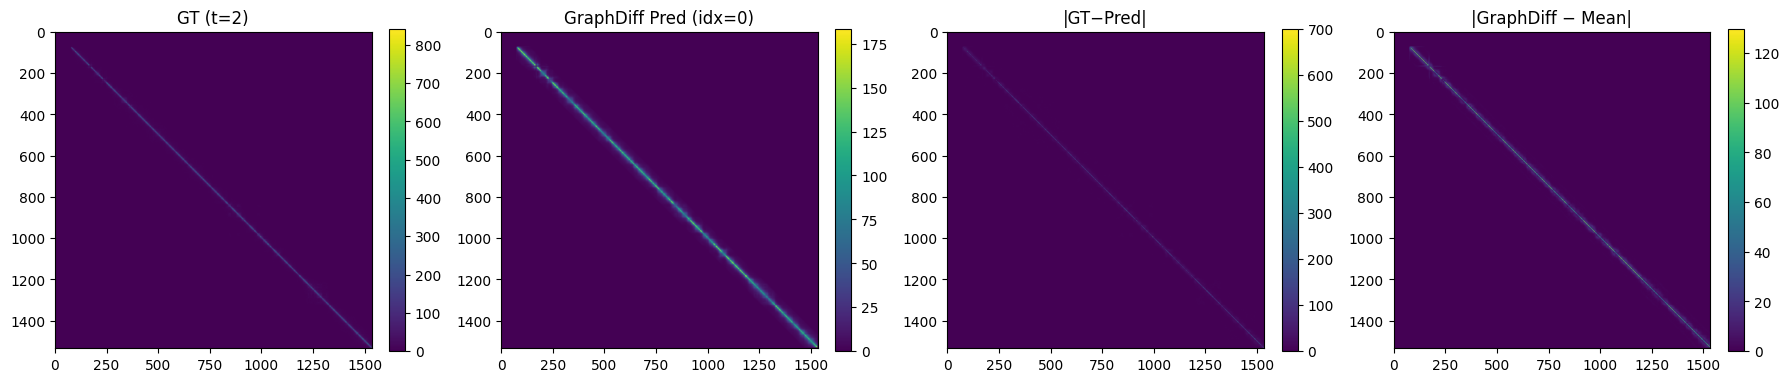

Saved: /content/drive/MyDrive/HiCForecast_Project_experiment_2/fig_gt_pred_diff_graphdiff_pred0_gt2.png


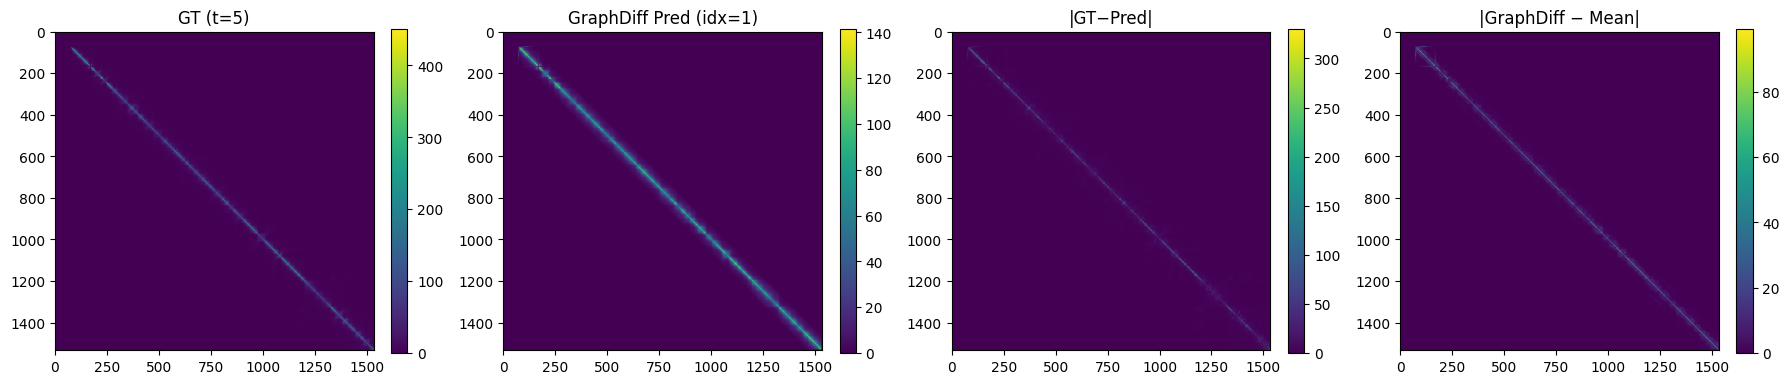

Saved: /content/drive/MyDrive/HiCForecast_Project_experiment_2/fig_gt_pred_diff_graphdiff_pred1_gt5.png


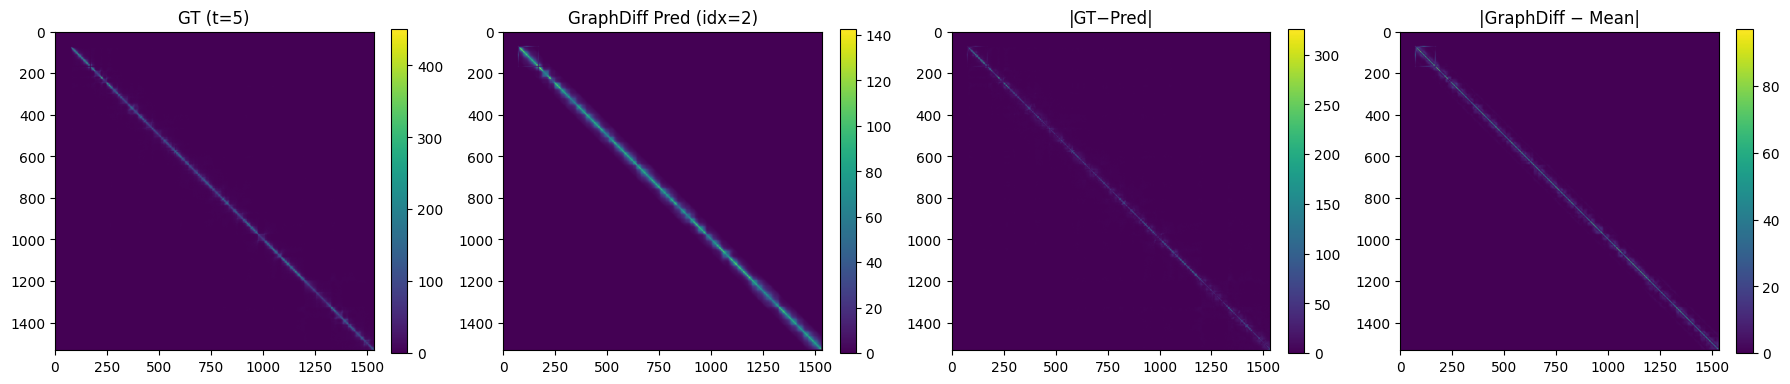

Saved: /content/drive/MyDrive/HiCForecast_Project_experiment_2/fig_gt_pred_diff_graphdiff_pred2_gt5.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

OUT_DIR = "/content/drive/MyDrive/HiCForecast_Project_experiment_2"
UNC_DIR = "/content/drive/MyDrive/HiCForecast_Project_experiment_1/runs/20260118_101729_result_uncertainty"

pred_graph = np.load(f"{OUT_DIR}/pred_graphdiff.npy").astype(np.float32)
pred_mean  = np.load(f"{UNC_DIR}/pred_uncertainty_mean.npy").astype(np.float32)
gt         = np.load(f"{OUT_DIR}/gt_chr19.npy").astype(np.float32)

fixed = [2, 5, 5]

for i in range(3):
    t = fixed[i]
    X = gt[t]
    Y = pred_graph[i]
    D = np.abs(X - Y)
    C = np.abs(Y - pred_mean[i])  # how much graph diffusion changed the prediction

    plt.figure(figsize=(18,4))
    plt.subplot(1,4,1); plt.title(f"GT (t={t})"); plt.imshow(X); plt.colorbar(fraction=0.046)
    plt.subplot(1,4,2); plt.title(f"GraphDiff Pred (idx={i})"); plt.imshow(Y); plt.colorbar(fraction=0.046)
    plt.subplot(1,4,3); plt.title("|GT−Pred|"); plt.imshow(D); plt.colorbar(fraction=0.046)
    plt.subplot(1,4,4); plt.title("|GraphDiff − Mean|"); plt.imshow(C); plt.colorbar(fraction=0.046)
    plt.tight_layout()

    out_fig = f"{OUT_DIR}/fig_gt_pred_diff_graphdiff_pred{i}_gt{t}.png"
    plt.savefig(out_fig, dpi=200)
    plt.show()
    print("Saved:", out_fig)